# Preprocessing and clustering 3k PBMCs

In May 2017, this started out as a demonstration that Scanpy would allow to reproduce most of Seurat's [guided clustering tutorial](http://satijalab.org/seurat/pbmc3k_tutorial.html) ([Satija et al., 2015](https://doi.org/10.1038/nbt.3192)).

We gratefully acknowledge Seurat's authors for the tutorial! In the meanwhile, we have added and removed a few pieces.
    
The data consist in *3k PBMCs from a Healthy Donor* and are freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.

In [1]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

<div class="alert alert-info">

**Note**
    
Download the notebook by clicking on the _Edit on GitHub_ button. On GitHub, you can download using the _Raw_ button via right-click and _Save Link As_. Alternatively, download the whole [scanpy-tutorial](https://github.com/theislab/scanpy-tutorials) repository.

</div>  

<div class="alert alert-info">

**Note**
    
In Jupyter notebooks and lab, you can see the documentation for a python function by hitting ``SHIFT + TAB``. Hit it twice to expand the view.

</div>

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import utils as ut

In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.jpeg_quality rcparam was deprecated in M

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.2 scipy==1.5.2 pandas==1.1.2 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.2 leidenalg==0.8.1


In [4]:
results_file = 'saved/results/scanpyGDSC.h5ad'  # the file that will store the analysis results
select_drug = 'Gefitinib'

na = -1

Read in the count matrix into an [`AnnData`](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5 file format: `.h5ad`.

In [6]:
# adata = sc.read_10x_mtx(
#     'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
#     var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
#     cache=True)                              # write a cache file for faster subsequent reading

data = pd.read_csv('data/GDSCexpression.csv',index_col=0)
label =pd.read_csv('data/GDSClabel.csv',index_col=0)

label =label.fillna(na)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [7]:
label.loc[:,"Gefitinib"]

BxPC-3        0.020293
KMOE-2        0.007419
MFM-223       0.003639
NUGC-3        0.153002
OC-314        0.020309
                ...   
KP-N-S19s    -1.000000
BC-3         -1.000000
Panc 08.13    0.009405
EKVX          0.126364
DMS-114       0.020822
Name: Gefitinib, Length: 789, dtype: float64

In [8]:
hvg,adata = ut.highly_variable_genes(data)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


## Preprocessing

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [50]:
#sc.pp.normalize_total(adata, target_sum=75000)

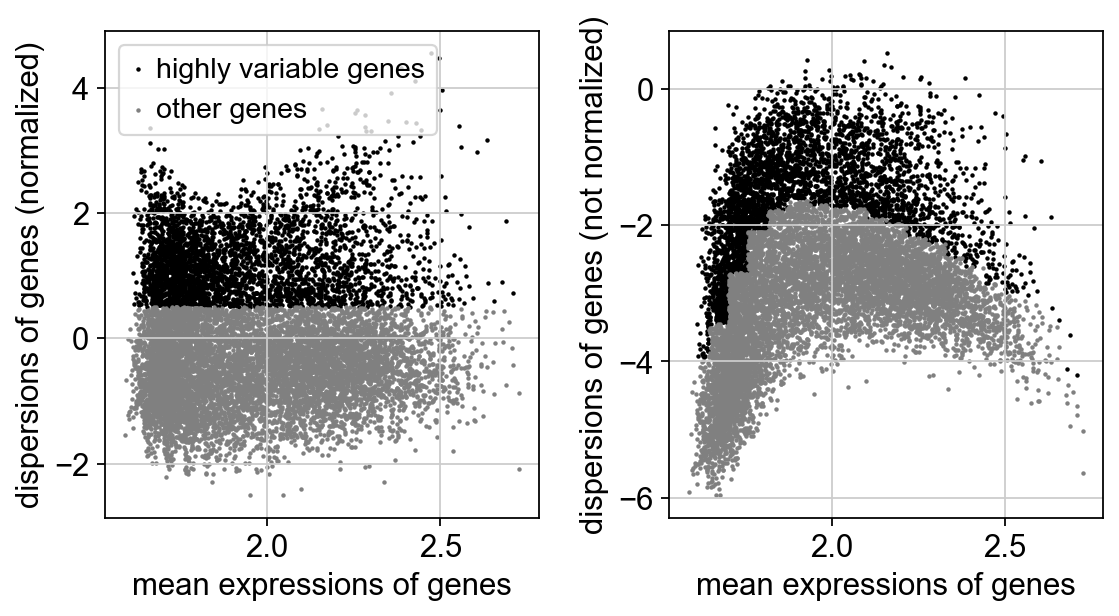

In [54]:
sc.pl.highly_variable_genes(adata,save="GDSC")

Set the `.raw` attribute of AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

<div class="alert alert-info">

**Note**

You can get back an `AnnData` of the object in `.raw` by calling `.raw.to_adata()`.

</div>    

In [18]:
adata.raw = adata

<div class="alert alert-info">

**Note**
    
If you don't proceed below with correcting the data with `sc.pp.regress_out` and scaling it via `sc.pp.scale`, you can also get away without using `.raw` at all.

The result of the previous highly-variable-genes detection is stored as an annotation in `.var.highly_variable` and auto-detected by PCA and hence, `sc.pp.neighbors` and subsequent manifold/graph tools. In that case, the step *actually do the filtering* below is unnecessary, too.

</div>

Actually do the filtering

In [19]:
adata = adata[:, adata.var.highly_variable]

D:\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [20]:
adata.var.highly_variable

ENSG00000000003_at    True
ENSG00000000938_at    True
ENSG00000000971_at    True
ENSG00000001084_at    True
ENSG00000001561_at    True
                      ... 
ENSG00000277586_at    True
ENSG00000277734_at    True
ENSG00000278828_at    True
ENSG00000279324_at    True
ENSG00000279364_at    True
Name: highly_variable, Length: 3460, dtype: bool

In [201]:
sum(adata.var.highly_variable == True)

3460

In [202]:
adata.obs_names

Index(['BxPC-3', 'KMOE-2', 'MFM-223', 'NUGC-3', 'OC-314', 'COLO-741',
       'KARPAS-45', 'JAR', 'DU-4475', 'MONO-MAC-6',
       ...
       'SF268', 'TK10', 'A2780', 'OVCAR-4-1', 'A375', 'KP-N-S19s', 'BC-3',
       'Panc 08.13-1', 'EKVX-1', 'DMS-114-1'],
      dtype='object', length=789)

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [203]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:05)


Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [204]:
sc.pp.scale(adata, max_value=10)

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [205]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


D:\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


We can make a scatter plot in the PCA coordinates, but we will not use that later on.

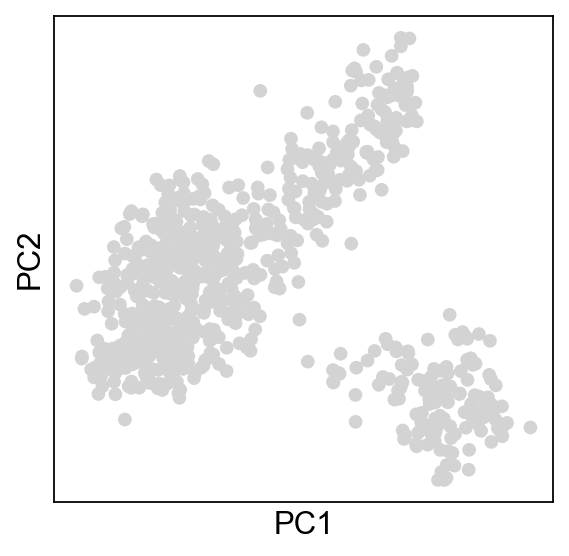

In [206]:
sc.pl.pca(adata,save="GDSC")

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine.

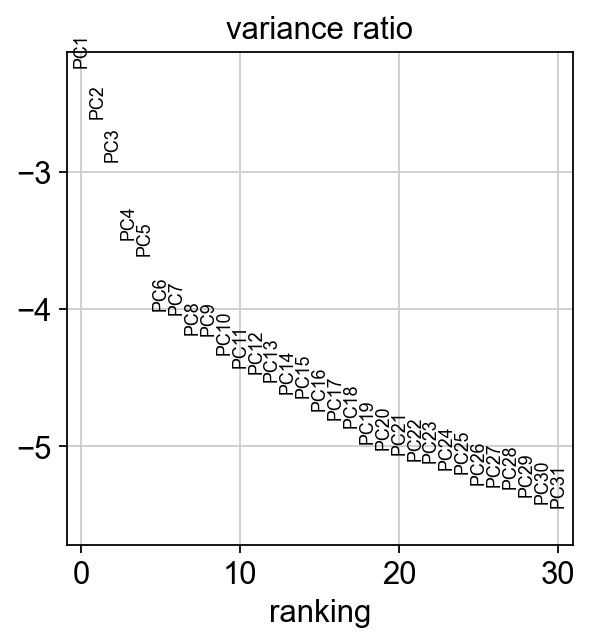

In [207]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result.

In [208]:
adata

AnnData object with n_obs × n_vars = 789 × 3460
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [209]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=16)

computing neighbors
    using 'X_pca' with n_pcs = 16
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


## Embedding the neighborhood graph

We advertise embedding the graph in 2 dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is  potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preservers trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')
```

In [210]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


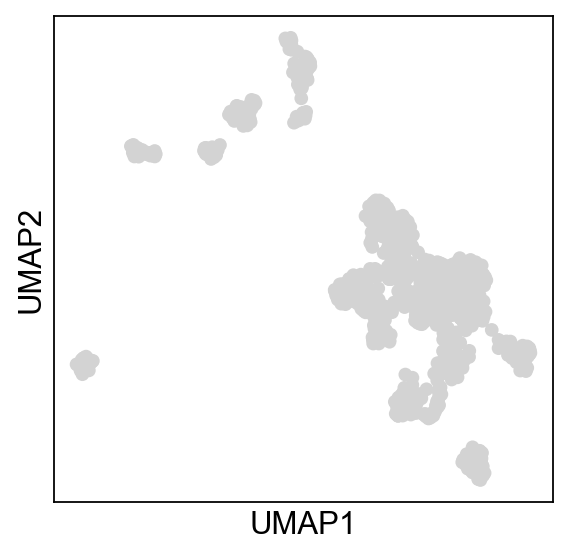

In [211]:
sc.pl.umap(adata)

As we set the `.raw` attribute of `adata`, the previous plots showed the "raw" (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don't want to use `.raw`.

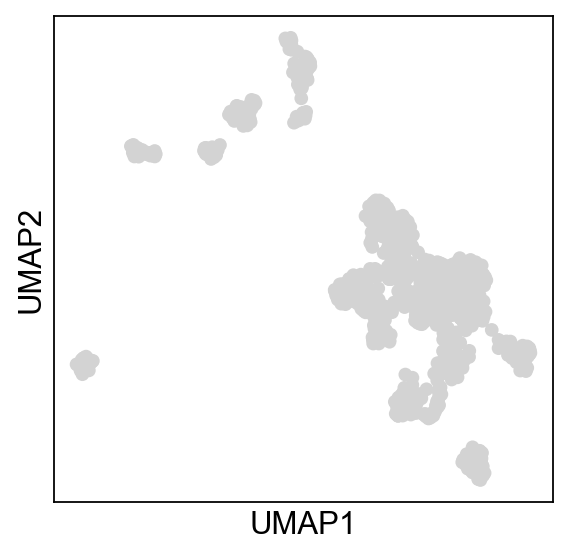

In [212]:
sc.pl.umap(adata, use_raw=False)

## Clustering the neighborhood graph

As Seurat and many others, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by [Traag *et al.* (2018)](https://scanpy.readthedocs.io/en/latest/references.html#traag18). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [213]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Plot the clusters, which agree quite well with the result of Seurat.

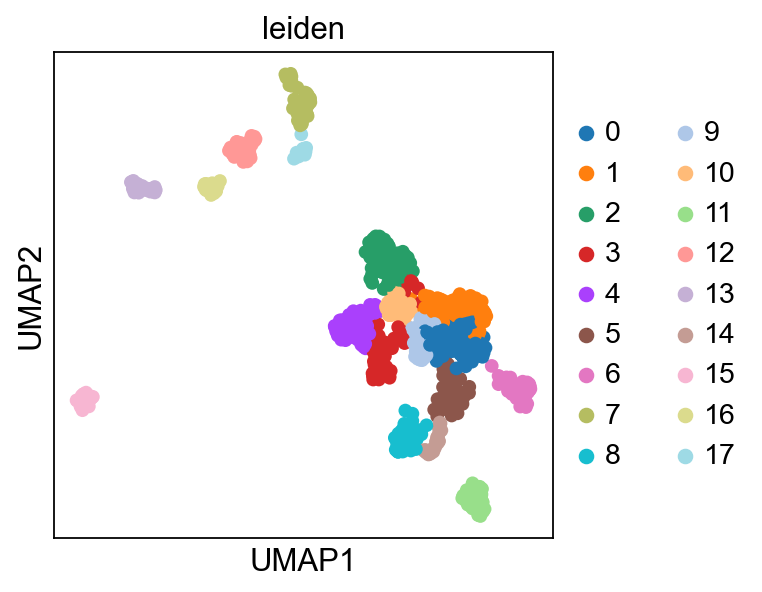

In [214]:
sc.pl.umap(adata, color=['leiden'],save="GDSC")

In [215]:
label

Erlotinib     AICAR  Camptothecin  Vinblastine  Cisplatin  \
BxPC-3      -1.000000  0.159708      0.188393     0.436127   0.154274   
KMOE-2       0.002108  0.339814      0.318206     0.281740   0.063808   
MFM-223      0.002148  0.334087      0.122671     0.361438   0.051983   
NUGC-3      -1.000000  0.095099      0.416792     0.422631   0.266409   
OC-314      -1.000000  0.012740      0.479915     0.390145   0.067738   
...               ...       ...           ...          ...        ...   
KP-N-S19s   -1.000000 -1.000000     -1.000000    -1.000000  -1.000000   
BC-3         0.003515 -1.000000     -1.000000    -1.000000  -1.000000   
Panc 08.13  -1.000000  0.152818      0.196279     0.180653   0.090963   
EKVX         0.177238  0.078395      0.078938     0.072213   0.007225   
DMS-114      0.000322  0.127677      0.168317     0.281940   0.092074   

            Cytarabine  Docetaxel  Methotrexate      ATRA  Gefitinib  ...  \
BxPC-3        0.113764   0.249987      0.015324  0.015324   0.020293  ...   
KMOE-2        0.140681   0.101530      0.191210  0.031229   0.007419  ...   
MFM-223       0.186659   0.228797      0.003639  0.023043   0.003639  ...   
NUGC-3        0.237811   0.234952      0.011558  0.028838   0.153002  ...   
OC-314        0.125869   0.249668      0.110418  0.002214   0.020309  ...   
...                ...        ...           ...       ...        ...  ...   
KP-N-S19s    -1.000000  -1.000000     -1.000000 -1.000000  -1.000000  ...   
BC-3         -1.000000  -1.000000     -1.000000 -1.000000  -1.000000  ...   
Panc 08.13    0.093197   0.097267      0.018269  0.010237   0.009405  ...   
EKVX          0.003470   0.129184      0.095642  0.111598   0.126364  ...   
DMS-114       0.191972   0.185916      0.007135  0.009329   0.020822  ...   

                 CMK  Pyrimethamine  JW-7-52-1  A-443654  GW843682X    MS-275  \
BxPC-3     -1.000000      -1.000000  -1.000000 -1.000000  -1.000000 -1.000000   
KMOE-2      0.022662       0.025217   0.270791  0.095608   0.139914  0.171747   
MFM-223     0.038997       0.006167   0.002185  0.102592   0.020338  0.010874   
NUGC-3     -1.000000      -1.000000  -1.000000 -1.000000  -1.000000 -1.000000   
OC-314     -1.000000      -1.000000  -1.000000 -1.000000  -1.000000 -1.000000   
...              ...            ...        ...       ...        ...       ...   
KP-N-S19s  -1.000000      -1.000000  -1.000000 -1.000000  -1.000000 -1.000000   
BC-3        0.048227       0.146476   0.400087  0.205247   0.147090  0.298803   
Panc 08.13 -1.000000      -1.000000  -1.000000 -1.000000  -1.000000 -1.000000   
EKVX        0.020472       0.044047   0.243635  0.079375   0.019859  0.177759   
DMS-114     0.002137       0.043920   0.285969  0.075195   0.174841  0.008383   

            Parthenolide    MG-132  KIN001-135    TGX221  
BxPC-3         -1.000000 -1.000000   -1.000000 -1.000000  
KMOE-2          0.026670  0.013904    0.002116  0.000956  
MFM-223         0.000970  0.035206    0.007051  0.000323  
NUGC-3         -1.000000 -1.000000   -1.000000 -1.000000  
OC-314         -1.000000 -1.000000   -1.000000 -1.000000  
...                  ...       ...         ...       ...  
KP-N-S19s      -1.000000 -1.000000   -1.000000 -1.000000  
BC-3            0.023796  0.017219    0.002065  0.069181  
Panc 08.13     -1.000000 -1.000000   -1.000000 -1.000000  
EKVX            0.014843  0.114431    0.007216  0.063911  
DMS-114         0.002135  0.080451    0.002135  0.028733  

[789 rows x 139 columns]

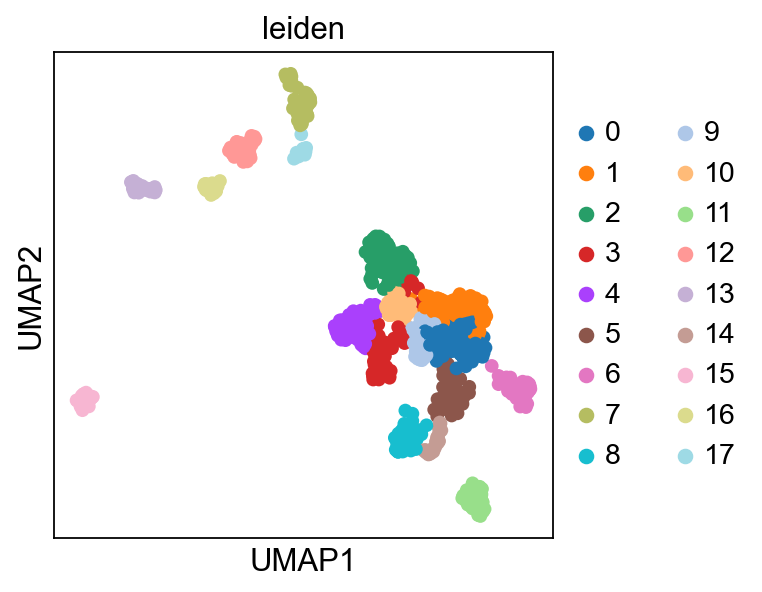

In [216]:
sc.pl.umap(adata, color=['leiden'],save="GDSC")

Save the result.

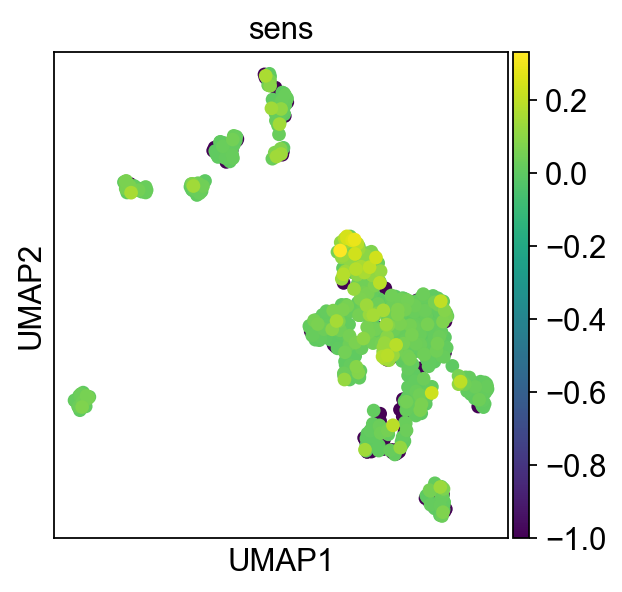

In [217]:
sens_result = adata.obs["leiden"]

sens_result = label.loc[:,select_drug]

sens_result.index = adata.obs["leiden"].index

adata.obs["sens"] = sens_result

sc.pl.umap(adata, color=['sens'],save="GDSCsens")

In [218]:
sc.tl.umap(adata, n_components=256)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


## Regression 

In [219]:
#label =label.fillna(0)

In [220]:
selected_idx = label.loc[:,select_drug]!=na

In [221]:
selected_idx

BxPC-3           True
KMOE-2           True
MFM-223          True
NUGC-3           True
OC-314           True
                ...  
KP-N-S19s       False
BC-3            False
Panc 08.13-1     True
EKVX-1           True
DMS-114-1        True
Name: Gefitinib, Length: 789, dtype: bool

In [222]:
data = adata.obsm["X_umap"]

In [223]:
label.shape

(789, 139)

In [224]:
X = data[selected_idx]
y = label.loc[selected_idx,select_drug]

from sklearn import preprocessing
scaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
X = scaler.fit_transform(X)

In [225]:
y

BxPC-3          0.020293
KMOE-2          0.007419
MFM-223         0.003639
NUGC-3          0.153002
OC-314          0.020309
                  ...   
OVCAR-4-1       0.057037
A375            0.038664
Panc 08.13-1    0.009405
EKVX-1          0.126364
DMS-114-1       0.020822
Name: Gefitinib, Length: 675, dtype: float64

In [226]:
#y = np.log(y)

In [227]:
y

BxPC-3          0.020293
KMOE-2          0.007419
MFM-223         0.003639
NUGC-3          0.153002
OC-314          0.020309
                  ...   
OVCAR-4-1       0.057037
A375            0.038664
Panc 08.13-1    0.009405
EKVX-1          0.126364
DMS-114-1       0.020822
Name: Gefitinib, Length: 675, dtype: float64

In [228]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, random_state=16)

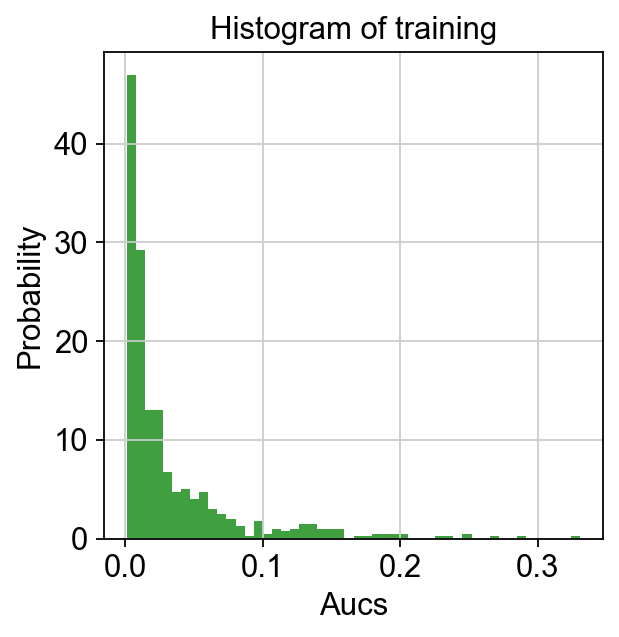

In [229]:
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)
# the histogram of the data
n, bins, patches = plt.hist(Y_train, 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('Aucs')
plt.ylabel('Probability')
plt.title('Histogram of training')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.xlim(40, 160)
# plt.ylim(0, 0.03)
# plt.grid(True)
plt.show()


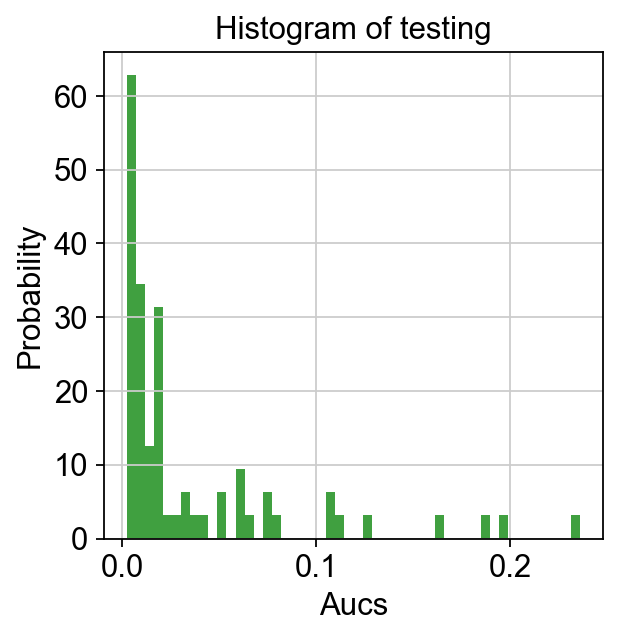

In [230]:
n, bins, patches = plt.hist(Y_test, 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('Aucs')
plt.ylabel('Probability')
plt.title('Histogram of testing')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.xlim(40, 160)
# plt.ylim(0, 0.03)
# plt.grid(True)
plt.show()


In [231]:
X_train

array([[ 1.0150172 , -0.8585568 ,  0.3160913 , ..., -0.3834984 ,
        -0.7595472 ,  0.9352816 ],
       [-0.3321419 , -0.43694207,  1.2666385 , ...,  0.78182787,
         0.2414792 ,  0.14962712],
       [-1.1135234 ,  2.2129483 , -0.37240723, ...,  0.77903616,
        -0.9494871 , -1.2639171 ],
       ...,
       [-2.5830746 , -0.5054879 ,  0.7729019 , ..., -1.482614  ,
         1.0851556 , -1.7651879 ],
       [-1.081276  ,  2.2496228 , -0.3667808 , ...,  0.8075505 ,
        -1.0027454 , -1.3781081 ],
       [ 0.02892668,  0.03834113, -0.18986101, ...,  0.5250327 ,
         0.08955975, -0.1637453 ]], dtype=float32)

In [232]:
y

BxPC-3          0.020293
KMOE-2          0.007419
MFM-223         0.003639
NUGC-3          0.153002
OC-314          0.020309
                  ...   
OVCAR-4-1       0.057037
A375            0.038664
Panc 08.13-1    0.009405
EKVX-1          0.126364
DMS-114-1       0.020822
Name: Gefitinib, Length: 675, dtype: float64

In [233]:
from sklearn.ensemble import AdaBoostRegressor
regr = AdaBoostRegressor(random_state=0, n_estimators=100)
regr.fit(X_train, Y_train.values)

AdaBoostRegressor(n_estimators=100, random_state=0)

In [234]:
from sklearn.ensemble import RandomForestRegressor #随机森林
rf = RandomForestRegressor()
rf.fit(X_train, Y_train.values)

RandomForestRegressor()

In [235]:
from sklearn.svm import SVR
svr = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svr.fit(X_train, Y_train.values)

SVR(C=100, degree=2, kernel='poly')

In [236]:
adaboost = regr.predict(X_test)
rfresult = rf.predict(X_test)
svrpredict = svr.predict(X_test)

In [237]:
from sklearn.metrics import r2_score

r2_score(svrpredict,Y_test)

-1.0026902065745928

In [248]:
r2_score(rfresult,Y_test)

-0.874213976125449

In [252]:
Y_test.values

array([0.076697, 0.027955, 0.018729, 0.00419 , 0.010027, 0.011032,
       0.009278, 0.031344, 0.05181 , 0.00611 , 0.006422, 0.00223 ,
       0.010638, 0.043371, 0.065803, 0.011799, 0.10575 , 0.020467,
       0.112077, 0.004105, 0.010284, 0.005831, 0.078179, 0.049048,
       0.01082 , 0.126217, 0.007132, 0.109388, 0.004246, 0.011068,
       0.015098, 0.008256, 0.018914, 0.0037  , 0.186092, 0.020309,
       0.030657, 0.00223 , 0.061828, 0.06083 , 0.16262 , 0.003716,
       0.004133, 0.012733, 0.018928, 0.016387, 0.005933, 0.017124,
       0.194723, 0.075604, 0.003639, 0.019657, 0.016319, 0.003632,
       0.003539, 0.012036, 0.236405, 0.019469, 0.023574, 0.035837,
       0.004063, 0.002564, 0.004757, 0.002186, 0.003647, 0.009405,
       0.011234, 0.059326])

In [253]:
rfresult

array([0.08348846, 0.07037817, 0.03258631, 0.00883559, 0.01159104,
       0.00702628, 0.02037835, 0.01062137, 0.03708574, 0.031339  ,
       0.02428469, 0.01853878, 0.03768827, 0.02093493, 0.05667179,
       0.02571689, 0.22351237, 0.0583013 , 0.10000216, 0.02434747,
       0.02028796, 0.01507277, 0.07267858, 0.03132222, 0.01111981,
       0.10659193, 0.008757  , 0.01194218, 0.00718921, 0.0264497 ,
       0.03819521, 0.03214828, 0.01757546, 0.01093311, 0.02416968,
       0.02331819, 0.01971998, 0.02194099, 0.0404855 , 0.07615198,
       0.03195244, 0.10262703, 0.0414709 , 0.02697107, 0.02655498,
       0.03854415, 0.04793255, 0.01362054, 0.01576359, 0.15111871,
       0.00884081, 0.03715605, 0.01279308, 0.05576299, 0.0191191 ,
       0.02352336, 0.07877378, 0.03408887, 0.0323344 , 0.01742991,
       0.03548893, 0.02889761, 0.01819165, 0.01270954, 0.01751532,
       0.03659348, 0.02533605, 0.06257391])

In [256]:
from scipy.stats import pearsonr
pearsonr(Y_test.values,adaboost)

(0.37691125124510616, 0.0015339250387546922)

In [239]:
r2_score(adaboost,Y_test)

-5.099571152262915

In [240]:
X_train

array([[ 1.0150172 , -0.8585568 ,  0.3160913 , ..., -0.3834984 ,
        -0.7595472 ,  0.9352816 ],
       [-0.3321419 , -0.43694207,  1.2666385 , ...,  0.78182787,
         0.2414792 ,  0.14962712],
       [-1.1135234 ,  2.2129483 , -0.37240723, ...,  0.77903616,
        -0.9494871 , -1.2639171 ],
       ...,
       [-2.5830746 , -0.5054879 ,  0.7729019 , ..., -1.482614  ,
         1.0851556 , -1.7651879 ],
       [-1.081276  ,  2.2496228 , -0.3667808 , ...,  0.8075505 ,
        -1.0027454 , -1.3781081 ],
       [ 0.02892668,  0.03834113, -0.18986101, ...,  0.5250327 ,
         0.08955975, -0.1637453 ]], dtype=float32)

In [241]:
Y_test.sort_values()

BT-549        0.002186
LK-2          0.002230
RPMI-2650     0.002230
EVSA-T        0.002564
SK-MM-2       0.003539
                ...   
LB1047-RCC    0.126217
RS4;11        0.162620
DU-145        0.186092
NCI-H716      0.194723
NCI-H292      0.236405
Name: Gefitinib, Length: 68, dtype: float64

In [242]:
y.loc["A375"]

0.038664

In [243]:
y.sort_values()

A704         0.000920
A704-1       0.000920
HCC1395      0.000990
NCI-H2141    0.002037
OCI-AML2     0.002086
               ...   
HSC-2-1      0.246505
HSC-2        0.246505
DOK          0.265463
CAL-27       0.286090
HSC-4        0.331080
Name: Gefitinib, Length: 675, dtype: float64

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


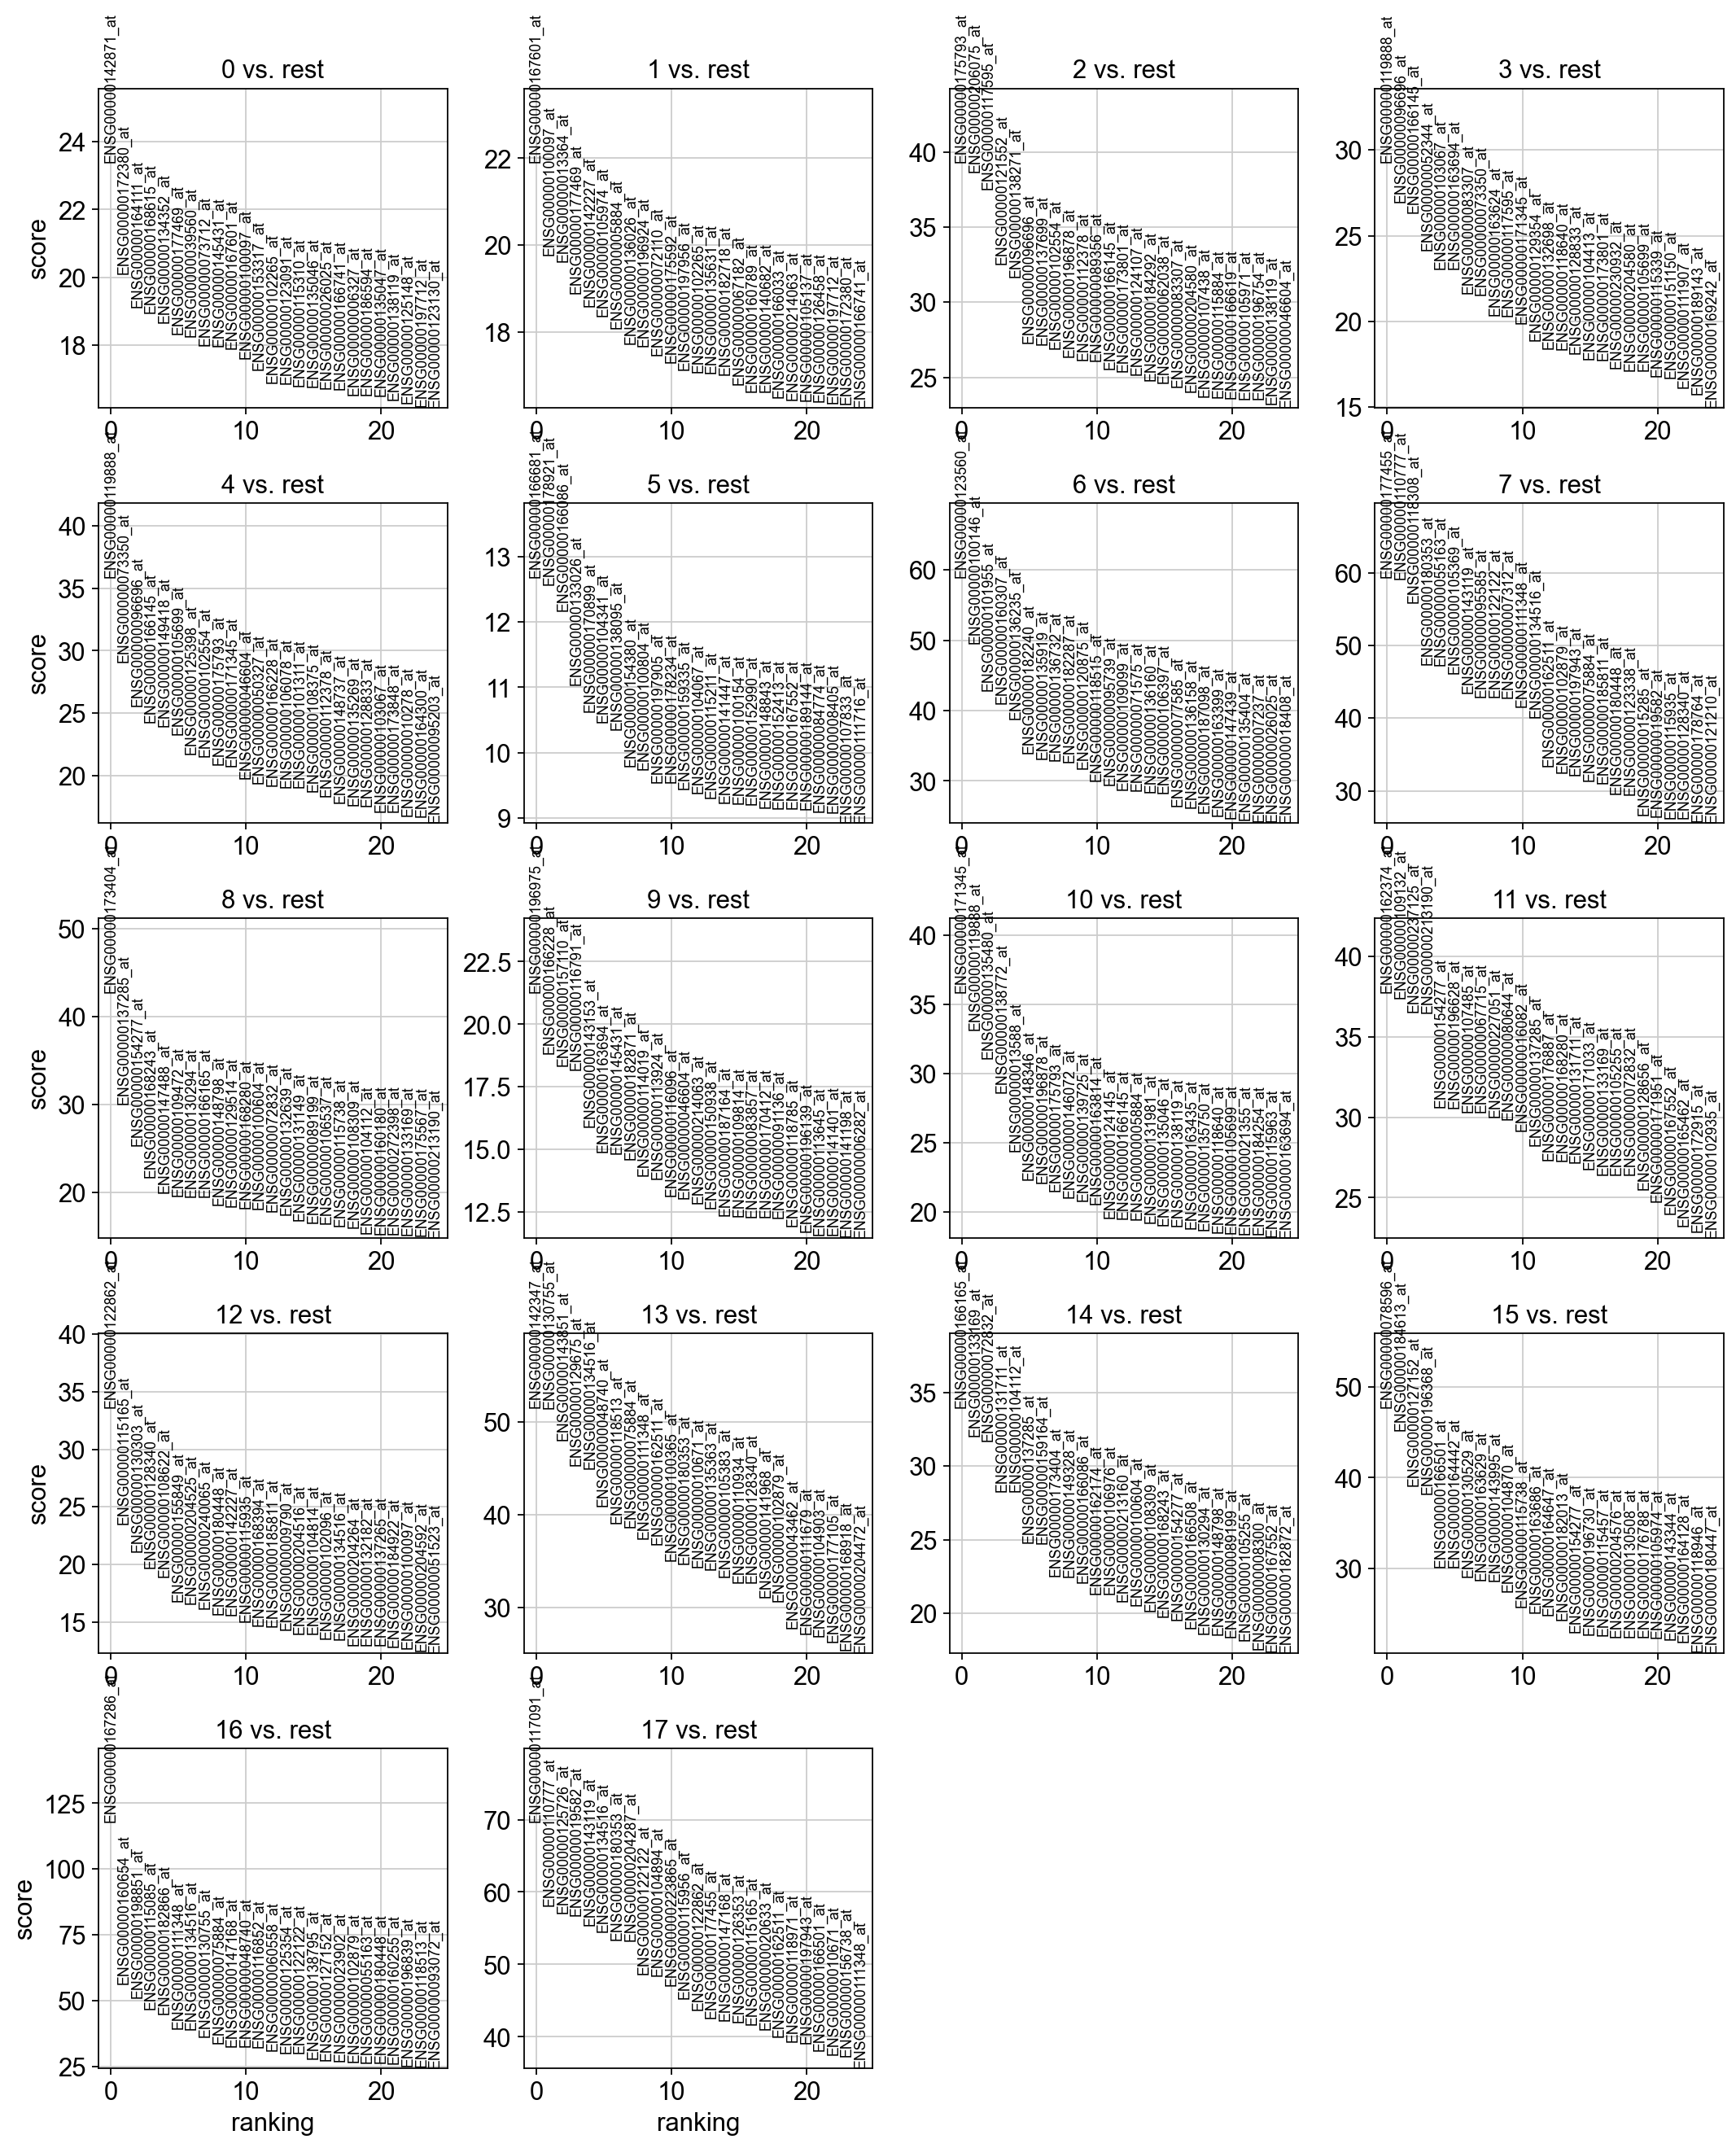

In [244]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False,save="GDSCDEG")

In [245]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://de.wikipedia.org/wiki/Wilcoxon-Mann-Whitney-Test) test is very similar. We recommend using the latter in publications, see e.g., [Sonison & Robinson (2018)](https://doi.org/10.1038/nmeth.4612). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

ranking genes
    finished (0:00:02)


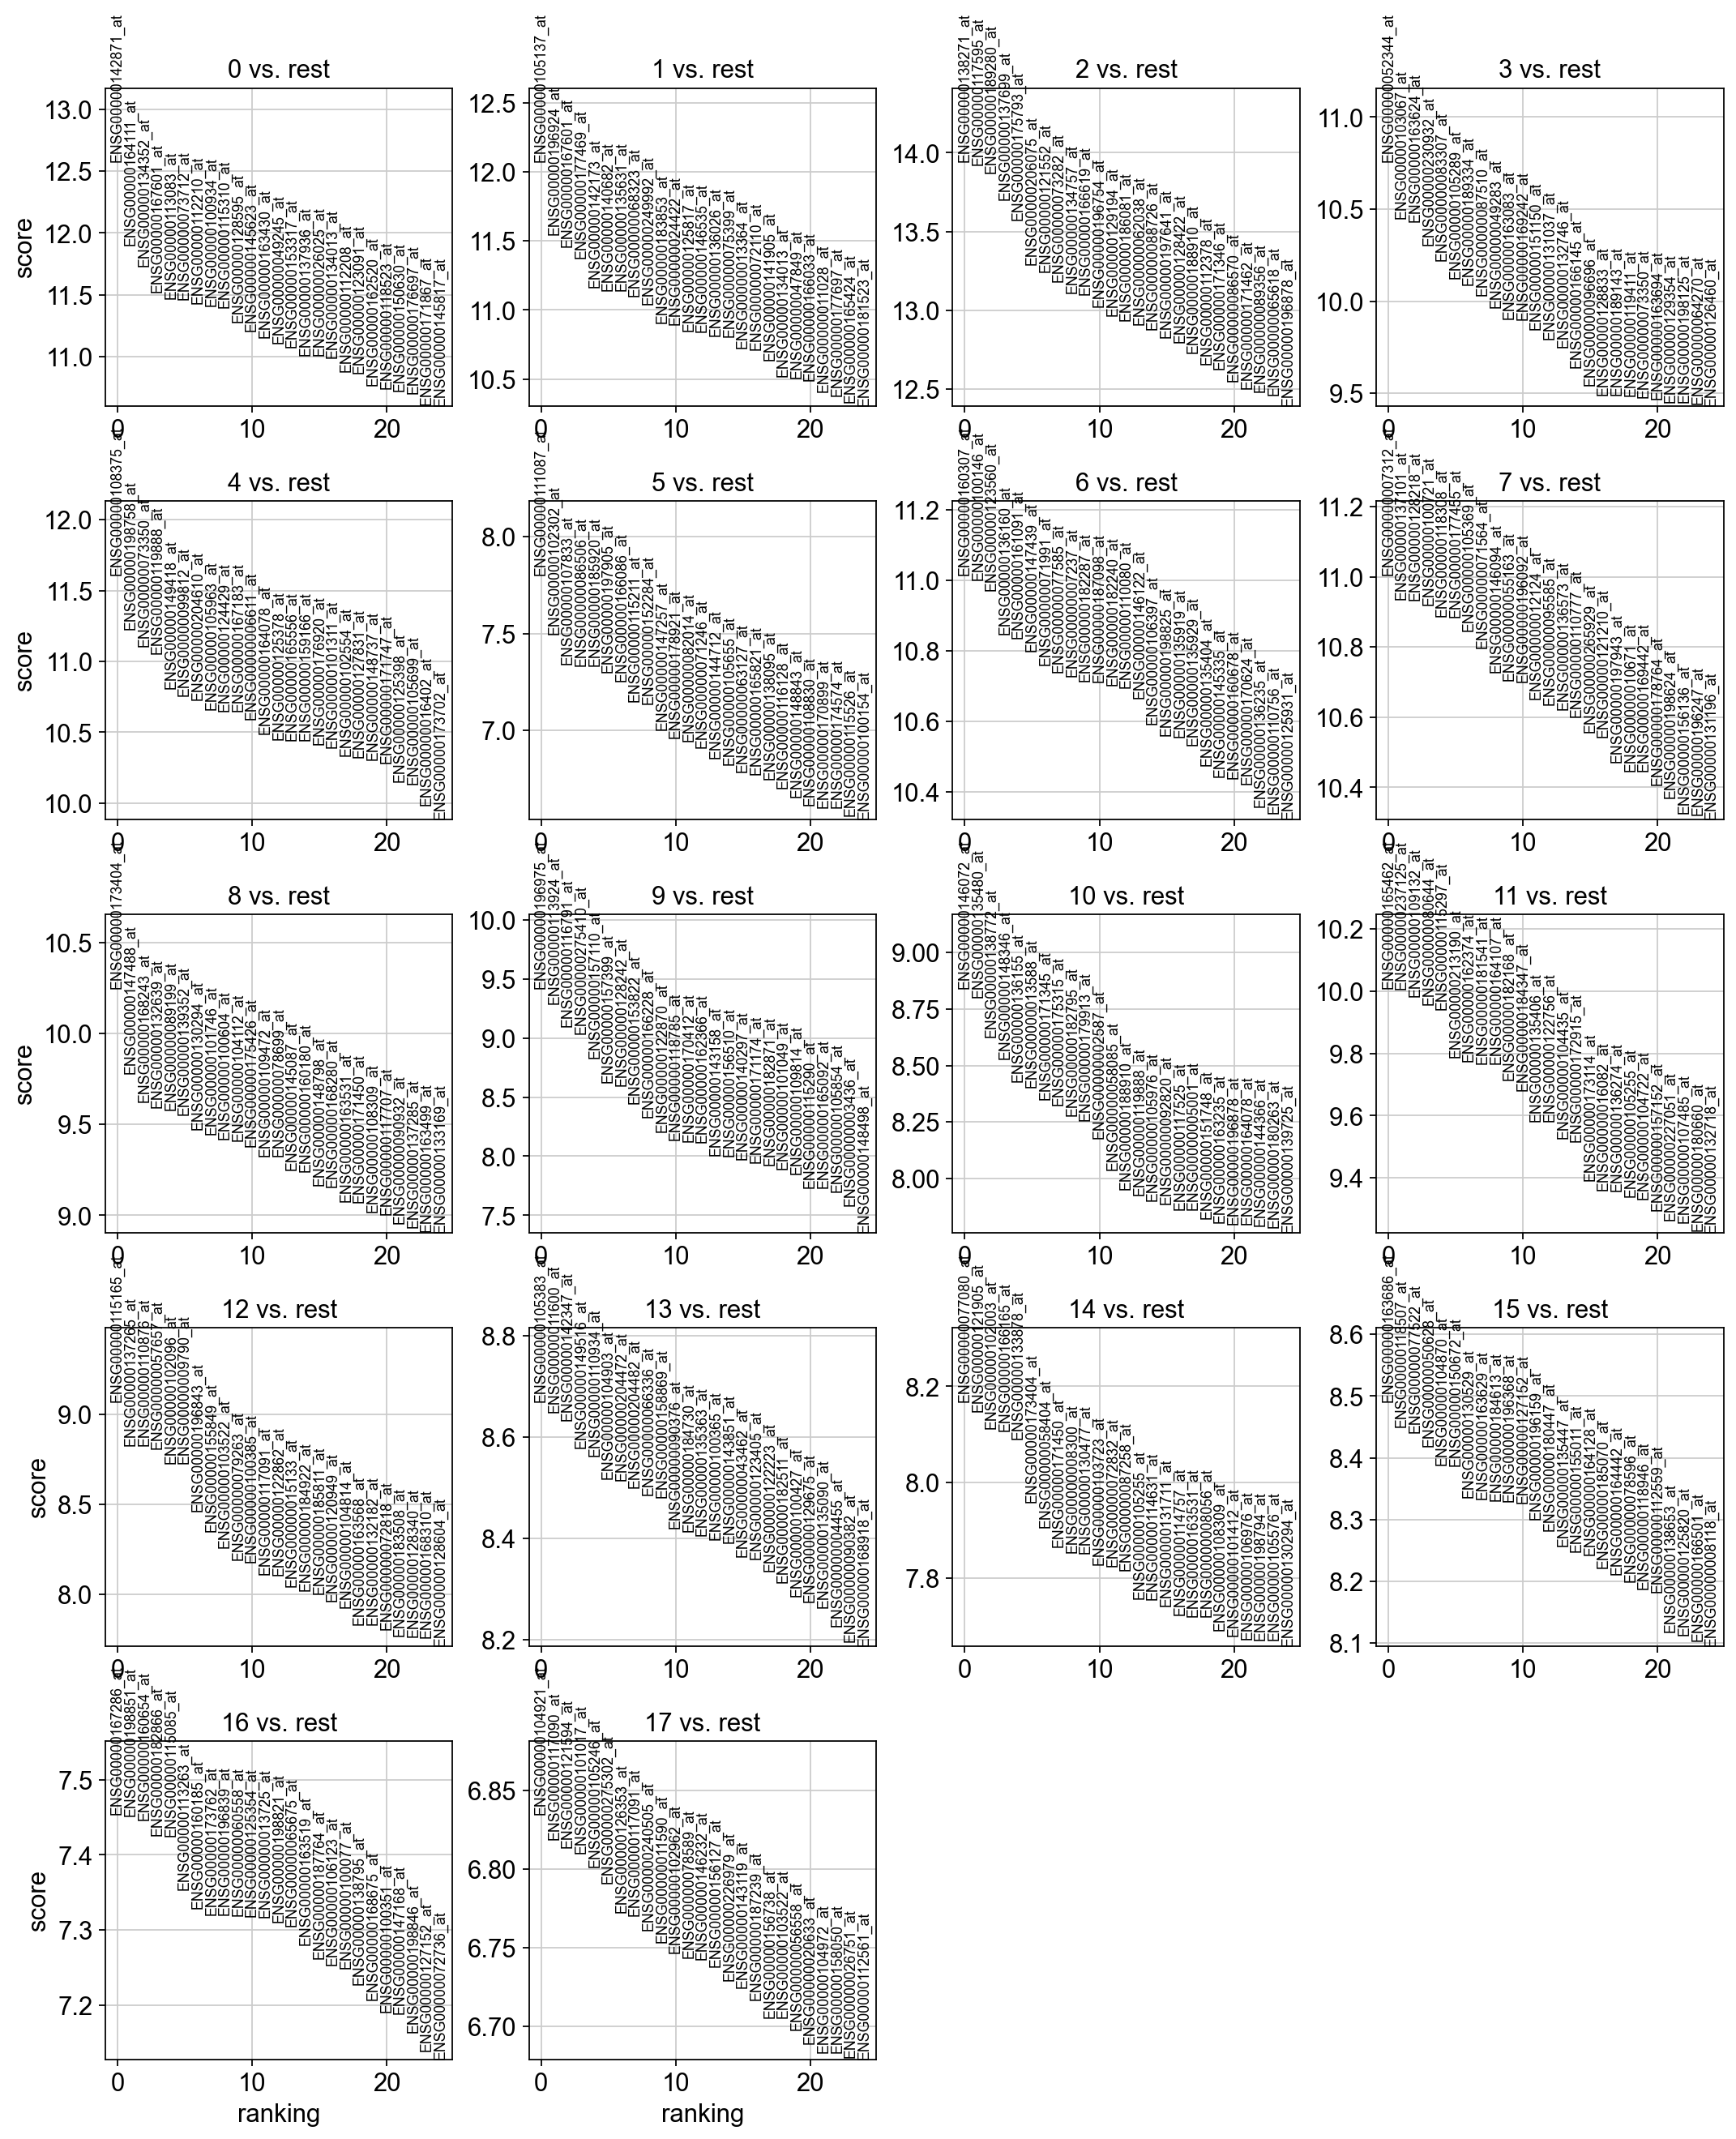

In [246]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the result.

In [247]:
adata.write(results_file)

OSError: Unable to create file (unable to open file: name = 'saved\results\scanpyGDSC.h5ad', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by [Natranos et al. (2018)](https://doi.org/10.1101/258566). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. [Clark et al. (2014)](https://doi.org/10.1186/1471-2105-15-79) has more details.

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Let us also define a list of marker genes for later reference.

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [ ]:
adata = sc.read(results_file)

Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

Get a table with the scores and groups.

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

Compare to a single cluster. 

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)